In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import constants
import itertools
import pandas as pd
from tabulate import tabulate
from matplotlib.lines import Line2D


%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8

In [2]:
epsilon_0 = constants.epsilon_0
c = constants.speed_of_light

fstart = 1
fstop = 10
fpoints = 100
f = np.logspace(fstart, fstop, fpoints)



l = 1e-8

In [3]:
num_of_sections = 16
num_of_combinations = 2**num_of_sections

# Generate all possible combinations of an 8-bit input
input_combinations = list(itertools.product([0, 1], repeat=num_of_sections))

# Convert the combinations to a NumPy array
input_matrix = np.array(input_combinations)

In [4]:
def plot_gammas(f, gamma_o, gamma_e):
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.semilogx(f, gamma_o)
    plt.ylabel("gamma_o")
    
    plt.subplot(2, 1, 2)
    plt.semilogx(f, gamma_e)
    plt.ylabel("gamma_e")

    plt.show()

In [5]:
'''Zo_off = 50
Ze_off = 48

Zo_on = 15.81
Ze_on = 15

gamma_o_on = 1j*np.sqrt( (30 + 600*np.exp(-1e-3*f)) )*2*np.pi*f/c
gamma_e_on = 1j*np.sqrt((7 + 150*np.exp(-1e-3*f)) )*2*np.pi*f/c

gamma_o_off = 1j*np.sqrt((-5 + 600*np.exp(-1e-3*f)) )*2*np.pi*f/c
gamma_e_off = 1j*np.sqrt((7 + 150*np.exp(-1e-3*f)) )*2*np.pi*f/c'''

'Zo_off = 50\nZe_off = 48\n\nZo_on = 15.81\nZe_on = 15\n\ngamma_o_on = 1j*np.sqrt( (30 + 600*np.exp(-1e-3*f)) )*2*np.pi*f/c\ngamma_e_on = 1j*np.sqrt((7 + 150*np.exp(-1e-3*f)) )*2*np.pi*f/c\n\ngamma_o_off = 1j*np.sqrt((-5 + 600*np.exp(-1e-3*f)) )*2*np.pi*f/c\ngamma_e_off = 1j*np.sqrt((7 + 150*np.exp(-1e-3*f)) )*2*np.pi*f/c'

## Prameters Setup

In [6]:
def Z_eff_2_L_C(Z0o, Z0e, eps_o, eps_e, L, T):
    c = constants.speed_of_light

    Lo = (Z0o/c)*np.sqrt(eps_o)
    Co_no_shunt = np.sqrt(eps_o)/(c*Z0o)

    Le = (Z0e/c)*np.sqrt(eps_e)
    Ce_no_shunt = np.sqrt(eps_e)/(c*Z0e)
    
    Ca = Ce_no_shunt
    Cm = (Co_no_shunt+Ce_no_shunt)/2

    Cst = (constants.epsilon_0*T)/(10e-5) # shunt capacitance

    return Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Cm, Cst

def L_C_2_Z_eff(Lo, Co_no_shunt, Le, Ce_no_shunt):
    c = constants.speed_of_light
    
    eps_o = (Co_no_shunt * Lo) * (c ** 2)
    Z0o = np.sqrt(Lo/Co_no_shunt)
    
    eps_e = (Ce_no_shunt * Le) * (c ** 2)
    Z0e = np.sqrt(Le/Ce_no_shunt)
        
    return Z0o, Z0e, eps_o/constants.epsilon_0, eps_e/constants.epsilon_0

def gamma_Z_2_LC(gamma_o, gamma_e, Zo, Ze):
    # odd
    Ro = np.real(gamma_o*Zo)
    Lo = np.imag(gamma_o*Zo)
    Go = np.real(gamma_o/Zo)
    Co = np.imag(gamma_o/Zo)
    # even
    Re = np.real(gamma_e*Ze)
    Le = np.imag(gamma_e*Ze)
    Ge = np.real(gamma_e/Ze)
    Ce = np.imag(gamma_e/Ze)

    return Ro, Lo, Go, Co, Re, Le, Ge, Ce

## Matrix Algebra

In [7]:
def invert_mat(A):
    inv_A = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=complex)
    for i in range(len(A[0, 0])):
        inv_A[:, :, i] = np.linalg.inv(A[:, :, i])

    return inv_A

def multiply_mat(A, B):
    C = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=complex)
    for i in range(len(A[0, 0, :])):
        C[:, :, i] = A[:, :, i] @ B[:, :, i]

    return C

## Mode Extraction

In [8]:
def odd_mode_params(f, Lo, Cm, Ca, Gm, Ga, R):
    w = 2*np.pi*f
    Co = 2*Cm - Ca
    Go = 2*Gm + Ga
    Lo = Lo
    Ro = R
    #gamma_o = 1e-5 + 1j*(2*np.pi*w*np.sqrt(Lo*Co))
    gamma_o = np.sqrt( (1j*w*Lo + Ro)*(1j*w*(Co) + Go) )
    Z0o = np.sqrt((Ro+1j*w*Lo)/(Go + 1j*w*Co))


    f0_o = 1/(2*np.pi*np.sqrt(Lo*Co)) # frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the odd mode
    theta_o = (np.pi/2)*(f/f0_o)

    return Lo, Co, Go, Ro, gamma_o, Z0o, theta_o

def even_mode_params(f, Le, Cm, Ca, Gm, Ga, R):
    w = 2*np.pi*f
    Ce = Ca
    Ge = Ga
    Le = Le
    Re = R
    #gamma_e = 1e-4 + 1j*(2*np.pi*w*np.sqrt(Le*Ce))
    gamma_e = np.sqrt( (1j*w*Le + Re)*(1j*w*(Ce) + Ge) )
    Z0e = np.sqrt((Re+1j*w*Le)/(Ge + 1j*w*Ce))

    f0_e = 1/(2*np.pi*np.sqrt(Le*Ce)) #frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the even mode,
    theta_e = (np.pi/2)*(f/f0_e)

    return Le, Ce, Ge, Re, gamma_e, Z0e, theta_e


## Z matrix

In [9]:
def create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o):

    Z11 = -(1j/2) * np.abs( (Z0e*cot_theta_e + Z0o*cot_theta_o) )
    Z12 = -(1j/2) * np.abs( (Z0e*cot_theta_e - Z0o*cot_theta_o) )
    Z13 = -(1j/2) * np.abs( (Z0e*csc_theta_e - Z0o*csc_theta_o) )
    Z14 = -(1j/2) * np.abs( (Z0e*csc_theta_e + Z0o*csc_theta_o) )


    Z = np.zeros((4, 4, len(Z11)), dtype=complex)

    Z[0][0][:] = Z11
    Z[1][1][:] = Z[0][0][:]
    Z[2][2][:] = Z[0][0][:]
    Z[3][3][:] = Z[0][0][:]

    Z[0][1][:] = Z12
    Z[1][0][:] = Z[0][1][:]
    Z[2][3][:] = Z[0][1][:]
    Z[3][2][:] = Z[0][1][:]

    Z[0][2][:] = Z13
    Z[2][0][:] = Z[0][2][:]
    Z[1][3][:] = Z[0][2][:]
    Z[3][1][:] = Z[0][2][:]

    Z[0][3][:] = Z14
    Z[3][0][:] = Z[0][3][:]
    Z[1][2][:] = Z[0][3][:]
    Z[2][1][:] = Z[0][3][:]

    return Z

## Z $\to$ S and S $\to$ Z

In [10]:
def create_F(Z01, Z02, Z03, Z04):
    F = np.zeros((4, 4, len(Z01)), dtype=np.complex128)
    F[0][0][:] = 1/(2*np.sqrt(Z01))
    F[1][1][:] = 1/(2*np.sqrt(Z02))
    F[2][2][:] = 1/(2*np.sqrt(Z03))
    F[3][3][:] = 1/(2*np.sqrt(Z04))
    return F

def create_G(Z01, Z02, Z03, Z04):
    G = np.zeros((4, 4, len(Z01)), dtype=np.complex128)
    G[0][0][:] = Z01
    G[1][1][:] = Z02
    G[2][2][:] = Z03
    G[3][3][:] = Z04
    return G

def create_reduced_F(f):
    F = np.zeros((2, 2, len(f)), dtype=np.complex128)
    F[0][0][:] = 1/(2*np.sqrt(50))
    F[1][1][:] = 1/(2*np.sqrt(50))

    return F

def create_reduced_G(f):
    G = np.zeros((2, 2, len(f)), dtype=np.complex128)
    G[0][0][:] = 50
    G[1][1][:] = 50

    return G

def z2s(Z, F, G):
    
    # Calculate Z - G* and Z + G
    Z_minus_G_star = Z - np.conj(G)
    Z_plus_G = Z + G
    
    # Calculate the inverse of Z + G
    Z_plus_G_inv = invert_mat(Z_plus_G)
    
    # Calculate F^(-1)
    F_inv = invert_mat(F)
    
    # Calculate S = F(Z - G*)(Z + G)^(-1)F^(-1)
    S = multiply_mat(multiply_mat(F, Z_minus_G_star), multiply_mat(Z_plus_G_inv, F_inv))
    
    return S

def s2z(S, F, G):
    # Calculate the identity matrix I of the same shape as S
    I = np.zeros(S.shape, dtype=np.complex128)
    for i in range(S.shape[2]):
        I[:, :, i] = np.eye(4, dtype=np.complex128)
    
    # Calculate (I - S)^(-1)
    I_minus_S_inv = invert_mat(I - S)
    
    # Calculate SG + G*
    SG_plus_G_star = multiply_mat(S, G) + np.conj(G)
    
    # Calculate F^(-1)
    F_inv = invert_mat(F)
    
    # Calculate Z = F^(-1)(I - S)^(-1)(SG + G*)F
    Z = multiply_mat(multiply_mat(F_inv, I_minus_S_inv), multiply_mat(SG_plus_G_star, F))
    
    return Z

## Create S Matrix

In [11]:
def create_S_off(f, Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Gm, Ga, R):
    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_no_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_no_shunt, Ca, Gm, Ga, R)

    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)

    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)

    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    return z2s(Z, F, G) # convert to S parameters for cascading

def create_S_on(f, Lo, Co_plus_shunt, Le, Ce_plus_shunt, Ca, Gm, Ga, R):
    Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, Lo, Co_plus_shunt, Ca, Gm, Ga, R)
    Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, Le, Ce_plus_shunt, Ca, Gm, Ga, R)

    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)

    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)

    Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)

    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    return z2s(Z, F, G) # convert to S parameters for cascading

## Create S matrix for given index

In [12]:
def find_index_Gamma(Zc, ZL, gamma, l):
    X = np.exp(-gamma*l)
    Gamma = (Zc-ZL)/(Zc+ZL)

    return X, Gamma

def find_S_current_index_odd_even(Zc, ZL, gamma, l):
    X, Gamma = find_index_Gamma(Zc, ZL, gamma, l)

    S = np.zeros((2, 2, len(f)), dtype=complex)

    S11 = (1-X**2)*Gamma/(1-X**2*Gamma**2)
    S22 = S11

    S12 = (1-Gamma**2)*X/(1-X**2*Gamma**2)
    S21 = S12

    S[0, 0, :] = S11
    S[0, 1, :] = S12
    S[1, 0, :] = S21
    S[1, 1, :] = S22

    return S

def find_4x4_S_matrix(Zc_o, ZL_o, gamma_o, Zc_e, ZL_e, gamma_e, l):
    S_even = find_S_current_index_odd_even(Zc_e, ZL_e, gamma_e, l)
    S_odd = find_S_current_index_odd_even(Zc_o, ZL_o, gamma_o, l)

    S1 = np.concatenate((S_odd, S_even), axis=1)
    S2 = np.concatenate((S_even, S_odd), axis=1)

    S = np.concatenate((S1, S2), axis=0)
    return S


## 2-Port Convertors

In [13]:
# V2 = 0 and I3 = 0 - reduces the matrix to that of a 2 port system

# Configuration 1: Ports 1 and 2 Retained (Ports 3 and 4 Eliminated)
def reduce_config1(Z):
    return Z[np.ix_([0, 1], [0, 1])]

# Configuration 2: Ports 1 and 3 Retained (Ports 2 and 4 Eliminated)
def reduce_config2(Z):
    return Z[np.ix_([0, 2], [0, 2])]

# Configuration 3: Ports 1 and 4 Retained (Ports 2 and 3 Eliminated)
def reduce_config3(Z):
    return Z[np.ix_([0, 3], [0, 3])]

# Configuration 4: Ports 2 and 3 Retained (Ports 1 and 4 Eliminated)
def reduce_config4(Z):
    return Z[np.ix_([1, 2], [1, 2])]



def convert_final_S_to_2_port_S_config_1(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_lpf = reduce_config1(Z)
    return z2s(Z_lpf, create_reduced_F(f), create_reduced_G(f))

def convert_final_S_to_2_port_S_config_2(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config1(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))

def convert_final_S_to_2_port_S_config_3(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config3(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))


def convert_final_S_to_2_port_S_config_4(S):
    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config4(Z)
    return z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))

## Imput Impedance

In [14]:
def find_Zin(ZL, Zc, gamma, l):
    return Zc * ( (ZL + 1j*Zc*np.tan(gamma*l))/(Zc + 1j*ZL*np.tan(gamma*l)) )

def create_possible_impedances_matrix(f, num_of_sections, L, C, gamma, l):
    imp = np.zeros((f, num_of_sections), dtype=complex)
    Zin = 50*np.ones(len(f))
    for i in range(num_of_sections):
        Zin = find_Zin(Zin, np.sqrt(L/C), gamma, l)
        imp[i] = Zin
    return imp

def find_imput_impedances(num_of_sections, index, L, C_curr, gamma, l, f):
    Z01 = 50*np.ones(len(f))
    Z03 = Z01

    for i in range(0, index):
        Z01 = find_Zin(Z01, np.sqrt(L/C_curr[i]), gamma, l)
    
    for i in range(num_of_sections-1, index, -1):
        Z03 = find_Zin(Z03, np.sqrt(L/C_curr[i]), gamma, l)

    Z02 = Z01
    Z04 = Z03

    return Z01, Z02, Z03, Z04


def plot_off_even_Z_in(f, Z0o, Z0e, gamma_o, gamma_e, l):

    Zin_o = find_Zin(50*np.ones(len(f)), Z0o, gamma_o, l)
    Zin_e = find_Zin(50*np.ones(len(f)), Z0e, gamma_e, l)
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    
    # Plot real and imaginary parts of Zin_e
    ax1.semilogx(f, np.real(Zin_e), label='Real(Zin_e)')
    ax1.semilogx(f, np.imag(Zin_e), label='Imag(Zin_e)')
    ax1.set_xlabel('Frequency (f)')
    ax1.set_ylabel('Impedance')
    ax1.set_title('Zin_e')
    ax1.legend()

    # Plot real and imaginary parts of Zin_o
    ax2.semilogx(f, np.real(Zin_o), label='Real(Zin_o)')
    ax2.semilogx(f, np.imag(Zin_o), label='Imag(Zin_o)')
    ax2.set_xlabel('Frequency (f)')
    ax2.set_ylabel('Impedance')
    ax2.set_title('Zin_o')
    ax2.legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

## Plots

In [15]:
def plot_S_params(f, S, title):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    for i in range(4):
        ax.flat[i].semilogx(f, 20*np.log10(np.abs(S[int(i/2), i%2, :])))
        ax.flat[i].grid(True)  # Add grid lines
    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()

def plot_full_Z_params(f, Z, title):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(15, 15))
    for i in range(16):
        row = int(i / 4)
        col = i % 4

        # Create a new y-axis on the right side of the current axes
        ax2 = ax.flat[i].twinx()

        # Plot the real part on the left y-axis and imaginary part on the right y-axis
        ax.flat[i].semilogx(f, np.real(Z[row, col, :]), label='Real')
        ax2.semilogx(f, np.imag(Z[row, col, :]), label='Imaginary', color='red')

        # Set labels and legends
        #ax.flat[i].set_ylabel('Real', color='blue')
        #ax2.set_ylabel('Imaginary', color='red')
        ax.flat[i].grid(True)
        
        # Add legends
        lines_1, labels_1 = ax.flat[i].get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        lines = lines_1 + lines_2
        labels = labels_1 + labels_2
        ax.flat[i].legend(lines, labels)

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()


def plot_full_S_params(f, S, title):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(15, 15))
    for i in range(16):
        ax.flat[i].semilogx(f, 20*np.log10(np.abs(S[int(i/4), i%4, :])))
        ax.flat[i].grid(True)  # Add grid lines
    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    plt.show()

def plot_all_possible_S_params(f, S_storage, title, n):
    N = len(S_storage)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 8))

    # Create a list of legend entries
    legend_entries = []
    for j in range(0, N, int(N/n)):
        legend_entries.append(f"index={format(j, f'0{8}b')}")

    # Add a legend to each subplot
    for i in range(4):
        for j in range(0, N, int(N/n)):
            line, = ax.flat[i].semilogx(f, 20*np.log10(np.abs(S_storage[j][int(i/2), i%2, :])))
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)
    fig_S_params.legend(legend_entries)
    plt.show()


def plot_tan_csc(theta_o, theta_e):
    cot_theta_o = 1/np.tan(theta_o)
    cot_theta_e = 1/np.tan(theta_e)
    csc_theta_o = 1/np.sin(theta_o)
    csc_theta_e = 1/np.sin(theta_e)
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(theta_o, cot_theta_o)
    ax.flat[0].grid(True)  # Add grid lines
    ax.flat[1].semilogx(theta_e, cot_theta_e)
    ax.flat[1].grid(True)  # Add grid lines
    ax.flat[2].semilogx(theta_o, csc_theta_o)
    ax.flat[2].grid(True)  # Add grid lines
    ax.flat[3].semilogx(theta_e, cot_theta_e)
    ax.flat[3].grid(True)  # Add grid lines
    plt.show()


def plot_four_subplots_on_off(Ro_on, Ro_off, Lo_on, Lo_off, Go_on, Go_off, Co_on, Co_off):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Four Subplots (On and Off)")

    # Plot on and off data in the subplots
    axes[0, 0].plot(Ro_on, label="On")
    axes[0, 0].plot(Ro_off, label="Off")
    axes[0, 0].set_title("Ro")
    axes[0, 0].legend()

    axes[0, 1].plot(Lo_on, label="On")
    axes[0, 1].plot(Lo_off, label="Off")
    axes[0, 1].set_title("Lo")
    axes[0, 1].legend()

    axes[1, 0].plot(Go_on, label="On")
    axes[1, 0].plot(Go_off, label="Off")
    axes[1, 0].set_title("Go")
    axes[1, 0].legend()

    axes[1, 1].plot(Co_on, label="On")
    axes[1, 1].plot(Co_off, label="Off")
    axes[1, 1].set_title("Co")
    axes[1, 1].legend()

    # Add labels and customize as needed
    for ax in axes.flat:
        ax.set(xlabel="X-label", ylabel="Y-label")

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Show the plots
    plt.show()

# Example usage:
# Replace Ro_on, Ro_off, Lo_on, Lo_off, Go_on, Go_off, Co_on, Co_off with your data arrays
# plot_four_subplots_on_off(Ro_on, Ro_off, Lo_on, Lo_off, Go_on, Go_off, Co_on, Co_off)


def plot_four_subplots_real_imag(Z01, Z02, Z03, Z04):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle("Four Subplots (Real and Imaginary)")

    # Plot real and imaginary parts in the subplots
    axes[0, 0].plot(np.real(Z01), label="Real")
    axes[0, 0].plot(np.imag(Z01), label="Imaginary")
    axes[0, 0].set_title("Z01")
    axes[0, 0].legend()

    axes[0, 1].plot(np.real(Z02), label="Real")
    axes[0, 1].plot(np.imag(Z02), label="Imaginary")
    axes[0, 1].set_title("Z02")
    axes[0, 1].legend()

    axes[1, 0].plot(np.real(Z03), label="Real")
    axes[1, 0].plot(np.imag(Z03), label="Imaginary")
    axes[1, 0].set_title("Z03")
    axes[1, 0].legend()

    axes[1, 1].plot(np.real(Z04), label="Real")
    axes[1, 1].plot(np.imag(Z04), label="Imaginary")
    axes[1, 1].set_title("Z04")
    axes[1, 1].legend()

    # Add labels and customize as needed
    for ax in axes.flat:
        ax.set(xlabel="X-label", ylabel="Y-label")

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Show the plots
    plt.show()

# Example usage:
# Replace Z01, Z02, Z03, Z04 with your complex data arrays
# plot_four_subplots_real_imag(Z01, Z02, Z03, Z04)



In [16]:
#Lo, Co_no_shunt, Le, Ce_no_shunt, Ca, Cm, Cst = Z_eff_2_L_C(50, 48, 5*epsilon_0, 5*epsilon_0, l, 0.035e-6)
# Define the parameters of the quadratic function
a = 4.0  # Coefficient for the quadratic term
b = 1.0  # Coefficient for the linear term
c = 4.0e-7  # Coefficient for the constant term
x = np.linspace(6e-7, 4e-7, fpoints)  # You can adjust the range as needed
L = a * x**2 + b * x + c

k = 0.66
Lo = L*(1+k)
Le = L*(1-k)

Co_no_shunt = 0.6e-10
Ce_no_shunt = Co_no_shunt/1.2

Ca = Ce_no_shunt
Cm = Co_no_shunt

Cst = 10*Ce_no_shunt

R = np.linspace(1e2, 1.25e3, fpoints)/1e4
a = 4.0  # Coefficient for the quadratic term
b = 1.0  # Coefficient for the linear term
c = 4.0  # Coefficient for the constant term
x = np.linspace(1e2, 3e4, fpoints)  # You can adjust the range as needed
R = a * x**2 + b * x + c

Gm = np.linspace(90, 100, fpoints)
Ga = np.linspace(90, 100, fpoints)

C_odd = input_matrix*(Co_no_shunt+Cst) + (1-input_matrix)*Co_no_shunt # capacitance values for every single state
C_even = input_matrix*(Ce_no_shunt) + (1-input_matrix)*Ce_no_shunt # capacitance values for every single state

Lo_off, Co_off, Go_off, Ro_off, gamma_o_off, Z0o_off, theta_o_off = odd_mode_params(f, Lo, Cm, Ca, Gm, Ga, R)
Lo_on, Co_on, Go_on, Ro_on, gamma_o_on, Z0o_on, theta_o_on = odd_mode_params(f, Lo, Cm + Cst, Ca, Gm, Ga, R)

Le_off, Ce_off, Ge_off, Re_off, gamma_e_off, Z0e_off, theta_e_off = odd_mode_params(f, Le, Cm, Ca, Gm, Ga, R)
Le_on, Ce_on, Ge_on, Re_on, gamma_e_on, Z0e_on, theta_e_on = odd_mode_params(f, Le, Cm, Ca, Gm, Ga, R)

cot_theta_o_off = 1/np.tan(theta_o_off)
cot_theta_o_on = 1/np.tan(theta_o_on)

cot_theta_e_off = 1/np.tan(theta_e_off)
cot_theta_e_on = 1/np.tan(theta_e_on)

csc_theta_o_off = 1/np.sin(theta_o_off)
csc_theta_o_on = 1/np.sin(theta_o_on)

csc_theta_e_off = 1/np.sin(theta_e_off)
csc_theta_e_on = 1/np.sin(theta_e_on)

Zc_o_off = np.sqrt(Lo_off/Co_off)
Zc_e_off = np.sqrt(Le_off/Ce_off)
Zc_o_on = np.sqrt(Lo_on/Co_on)
Zc_e_on = np.sqrt(Le_on/Ce_on)


Z_mat_on = create_Z_matrix(Z0e_on, cot_theta_e_on, csc_theta_e_on, Z0o_on, cot_theta_o_on, csc_theta_o_on)
Z_mat_off = create_Z_matrix(Z0e_off, cot_theta_e_off, csc_theta_e_off, Z0o_off, cot_theta_o_off, csc_theta_o_off)

S_curr = np.zeros((4, 4, fpoints), dtype=complex)

In [17]:
def main():
    index = 0
    # Create the identity matrices for each fpoint
    identity_matrices = [np.eye(4, 4) for _ in range(fpoints)]

    # Stack the identity matrices along the third dimension
    S = np.stack(identity_matrices, axis=2)
    for j in range(num_of_sections):
        if input_matrix[index][j] == 1:
            Z01_odd, Z02_odd, Z03_odd, Z04_odd = find_imput_impedances(num_of_sections, j, Lo, C_odd[index][:], gamma_o_on, l, f)
            Z01_even, Z02_even, Z03_even, Z04_even = find_imput_impedances(num_of_sections, j, Le, C_even[index][:], gamma_e_on, l, f)
        else:
            Z01_odd, Z02_odd, Z03_odd, Z04_odd = find_imput_impedances(num_of_sections, j, Lo, C_odd[index][:], gamma_o_off, l, f)
            Z01_even, Z02_even, Z03_even, Z04_even = find_imput_impedances(num_of_sections, j, Le, C_even[index][:], gamma_e_off, l, f)

        if input_matrix[index][j] == 1:
            S_curr = find_4x4_S_matrix(Zc_o_on, Z03_odd, gamma_o_on, Zc_e_on, Z03_even, gamma_e_on, l)
        else:
            S_curr = find_4x4_S_matrix(Zc_o_off, Z03_odd, gamma_o_off, Zc_e_off, Z03_even, gamma_e_off, l)

        S = multiply_mat(S, S_curr)

    plot_full_S_params(f, S, "lol")

    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_bpf = reduce_config4(Z)

    S = z2s(Z, F, G)

    plot_S_params(f, S, "lol")
            

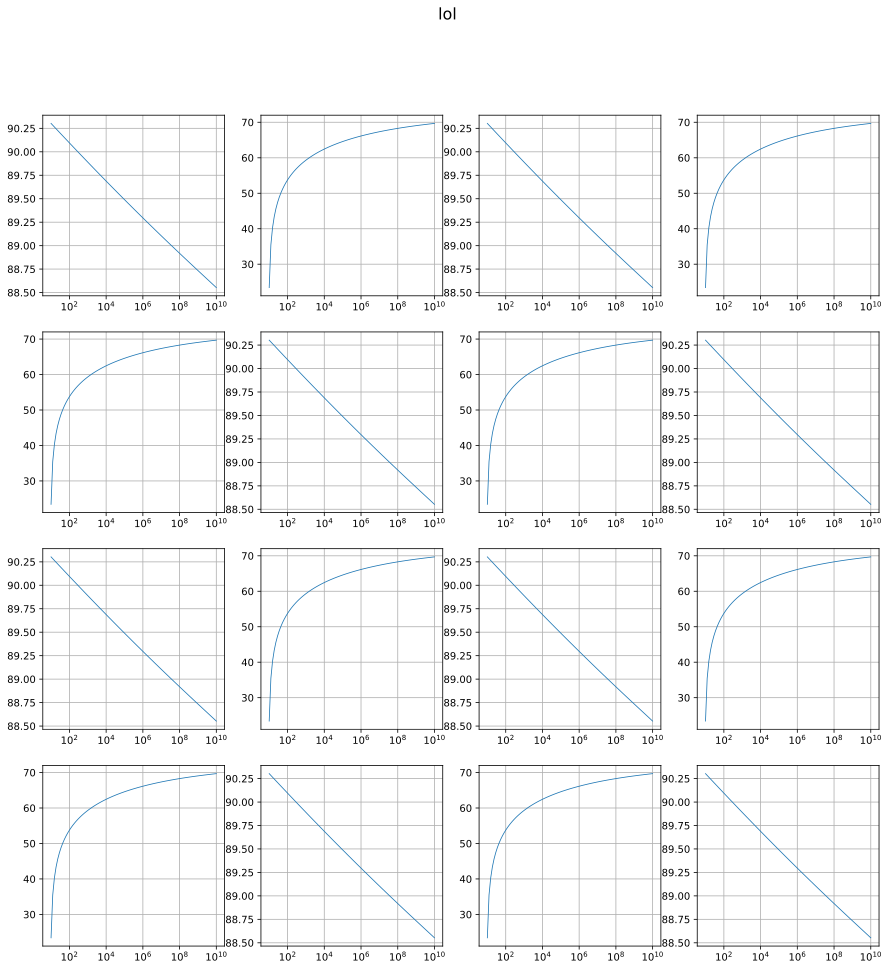

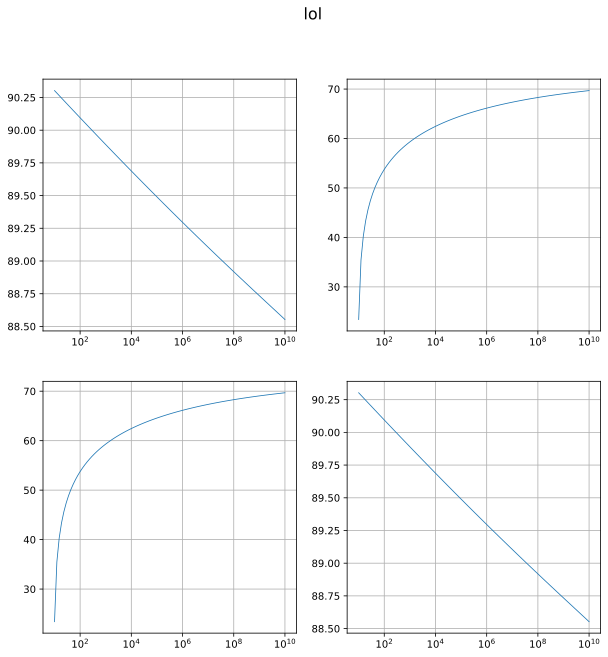

In [18]:
if __name__ == "__main__":
    main()